In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Data import and basic summary
np.random.seed(49)
DashData = pd.read_csv("C:/Users/Zach/Documents/GitHub/DoorDashModels/Data/historical_data.csv")
DashData.head(10)
DashData.info()
DashData.describe()
print("Percentange of missing value % :",DashData.isna().mean().mean()*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [4]:
#Creating the target variable for models
from datetime import datetime
DashData['created_at'] = pd.to_datetime(DashData['created_at'])
DashData["actual_delivery_time"] = pd.to_datetime(DashData["actual_delivery_time"])
DashData["Total_Delivery_Duration"] = (DashData["actual_delivery_time"] - DashData["created_at"]).dt.total_seconds()

DashData.head(10)
#New feature creations
DashData['Estimated_non_prep_duration'] = DashData["estimated_store_to_consumer_driving_duration"] + DashData["estimated_order_place_duration"]
DashData['BusyDriverRatio'] = DashData["total_busy_dashers"] / DashData["total_onshift_dashers"]
#Time features
DashData['Months'] = DashData['created_at'].dt.month
DashData['Quarter'] = DashData['created_at'].dt.quarter
#aggregate features
DashData['TotalOrderPerStore'] = DashData.groupby('store_id')['total_items'].transform('sum')
DashData['OrderValuePerStore'] = DashData.groupby('store_id')['total_items'].transform('mean')
DashData['OrderCountMonthsPerStore'] = DashData.groupby('Months')['total_items'].transform('sum')

#simple store metrics
avg_by_category= DashData.groupby('store_primary_category')['subtotal'].mean() / 100
print("Average subtotals per store category in dollars:")
print(avg_by_category)
std_by_category = DashData.groupby('store_primary_category')['subtotal'].std() / 100
print("\nStandard deviation of subtotals per store category in dollars:")
print(std_by_category)
print("Average order delivery time in minutes:")
print(f"{DashData['Total_Delivery_Duration'].mean()/60:.2f}")

DashData.head()



Average subtotals per store category in dollars:
store_primary_category
afghan               29.850756
african              26.997000
alcohol              26.565957
alcohol-plus-food    16.990000
american             26.585065
                       ...    
thai                 31.080275
turkish              28.858565
vegan                25.098029
vegetarian           26.007349
vietnamese           22.585660
Name: subtotal, Length: 74, dtype: float64

Standard deviation of subtotals per store category in dollars:
store_primary_category
afghan               17.588114
african              11.044908
alcohol              17.889367
alcohol-plus-food          NaN
american             16.910146
                       ...    
thai                 18.538711
turkish              16.714752
vegan                15.727010
vegetarian           15.437324
vietnamese           15.615800
Name: subtotal, Length: 74, dtype: float64
Average order delivery time in minutes:
48.47


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,Total_Delivery_Duration,Estimated_non_prep_duration,BusyDriverRatio,Months,Quarter,TotalOrderPerStore,OrderValuePerStore,OrderCountMonthsPerStore
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,...,446,861.0,3779.0,1307.0,0.424242,2,1,4,4.000000,411075
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,...,446,690.0,4024.0,1136.0,2.000000,2,1,37,2.846154,411075
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,...,446,690.0,1781.0,1136.0,0.000000,1,1,37,2.846154,219981
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,...,446,289.0,3075.0,735.0,1.000000,2,1,37,2.846154,411075
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,...,446,650.0,2390.0,1096.0,1.000000,2,1,37,2.846154,411075


In [5]:
#creating a dictionary for store categories to fill the null categories using the most common category -- could be better way to do with with SME
store_id_unique = DashData["store_id"].unique().tolist()
store_id_and_category = {store_id: DashData[DashData.store_id == store_id].store_primary_category.mode() 
                         for store_id in store_id_unique}
def fill(store_id):
    """Return primary store category from the dictionary"""
    try:
        return store_id_and_category[store_id].values[0]
    except:
        return np.nan

# fill null values
DashData["nan_free_store_primary_category"] = DashData.store_id.apply(fill)


In [6]:
#creating dummies
OrderProtocalDummies =pd.get_dummies(DashData.order_protocol, dtype=int)
OrderProtocalDummies = OrderProtocalDummies.add_prefix('OrderProtocal_')
#checking
OrderProtocalDummies.head()
MarketIdDummies = pd.get_dummies(DashData.market_id, dtype=int)
MarketIdDummies = MarketIdDummies.add_prefix('MarketId_')
#checking
MarketIdDummies.head()
StoreCategoryDummies = pd.get_dummies(DashData.nan_free_store_primary_category, dtype=int)
StoreCategoryDummies = StoreCategoryDummies.add_prefix('StoreCategory_')
#checking
StoreCategoryDummies.head()

,StoreCategory_afghan,StoreCategory_african,StoreCategory_alcohol,StoreCategory_alcohol-plus-food,StoreCategory_american,StoreCategory_argentine,StoreCategory_asian,StoreCategory_barbecue,StoreCategory_belgian,StoreCategory_brazilian,...,StoreCategory_southern,StoreCategory_spanish,StoreCategory_steak,StoreCategory_sushi,StoreCategory_tapas,StoreCategory_thai,StoreCategory_turkish,StoreCategory_vegan,StoreCategory_vegetarian,StoreCategory_vietnamese
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# defining the intial train DF
train_df = DashData.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time","nan_free_store_primary_category", "order_protocol"])
train_df.head()
#merging the dummies to train
train_df = pd.concat([train_df, OrderProtocalDummies, MarketIdDummies, StoreCategoryDummies], axis=1)
#checking
train_df.head()
#seeing which fetures that have infinte max value -- could be issue for models
if np.isinf(train_df).any().any():
    print("Features with infinite max value:")
    print(train_df.columns[np.isinf(train_df).any()])
else:
    print("No infinite values in the dataset")
#ensuring dtype synergy
train_df = train_df.astype("Float32")

Features with infinite max value:
Index(['BusyDriverRatio'], dtype='object')


In [9]:
#replacing infinite values in BusyDriverRatio with NaN then with the mean of the column
train_df["BusyDriverRatio"] = train_df["BusyDriverRatio"].replace([np.inf, -np.inf], np.nan)
train_df["BusyDriverRatio"] = train_df["BusyDriverRatio"].fillna(train_df["BusyDriverRatio"].mean())
#checking
train_df["BusyDriverRatio"].describe()


count    197428.0
mean     0.949777
std      0.385194
min         -13.0
25%      0.846154
50%      0.949778
75%           1.0
max          31.0
Name: BusyDriverRatio, dtype: Float64

<Axes: >

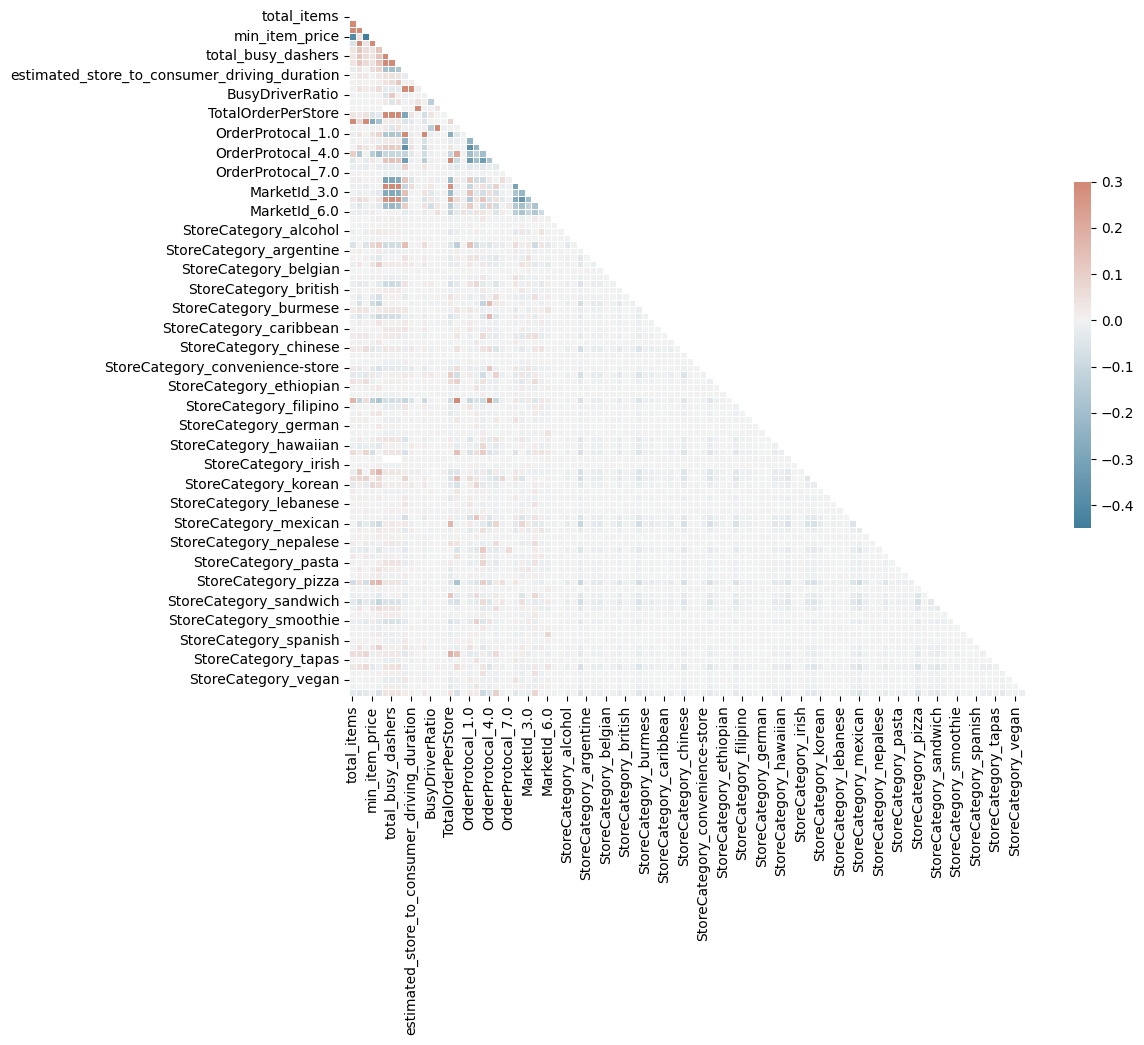

In [10]:
#Next Task (3/20): Removing Redundant and Potential Collinear Features to prepare for FAMD analysis
corrMatrix = train_df.corr()
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [68]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sorting correlations in the descending order and return n highest results"""
    AB_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    AB_corr = AB_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return AB_corr[0:n]

print("Top Absolute Correlations\n")
print(get_top_abs_correlations(train_df, 15))
#removing the features
train_df = DashData.drop(columns = ["created_at", "market_id", "store_id", "store_primary_category", "actual_delivery_time","nan_free_store_primary_category", "order_protocol"])
train_df = pd.concat([train_df, OrderProtocalDummies, MarketIdDummies, StoreCategoryDummies], axis=1)
# drop highly correlated features
train_df = train_df.drop(columns=["total_onshift_dashers", "total_busy_dashers","StoreCategory_indonesian",])
# align dtype over dataset
train_df = train_df.astype("float32")
# replace inf values with nan to drop all nans
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)


Top Absolute Correlations

total_items                                   OrderValuePerStore         0.438134
OrderValuePerStore                            StoreCategory_fast         0.390871
total_items                                   price_range_of_items       0.333304
total_outstanding_orders                      TotalOrderPerStore         0.323744
total_items                                   avg_price_per_item         0.310759
OrderValuePerStore                            avg_price_per_item         0.294780
TotalOrderPerStore                            StoreCategory_sushi        0.204031
estimated_store_to_consumer_driving_duration  Total_Delivery_Duration    0.188418
StoreCategory_fast                            avg_price_per_item         0.175950
total_items                                   StoreCategory_fast         0.170988
StoreCategory_italian                         avg_price_per_item         0.158193
total_outstanding_orders                      Total_Delivery_Duration  

In [69]:
#checking the abs cor again
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(train_df, 25))
#removing highly correlated features -- could be better with consulting SME for feature importance in dataset
train_df = train_df.drop(columns=["Months", "estimated_order_place_duration","Estimated_non_prep_duration",])


Top Absolute Correlations

Months                                        OrderCountMonthsPerStore       1.000000
estimated_store_to_consumer_driving_duration  Estimated_non_prep_duration    0.923086
estimated_order_place_duration                OrderProtocal_1.0              0.897645
total_items                                   num_distinct_items             0.758146
subtotal                                      num_distinct_items             0.682890
total_items                                   subtotal                       0.557175
min_item_price                                max_item_price                 0.541241
subtotal                                      max_item_price                 0.507947
OrderProtocal_4.0                             StoreCategory_fast             0.489946
num_distinct_items                            min_item_price                 0.446733
total_items                                   OrderValuePerStore             0.438134
MarketId_2.0               

In [70]:
#checking the abs cor again
print("Top Absolute Correlations\n")
print(get_top_abs_correlations(train_df, 25))

Top Absolute Correlations

total_items               num_distinct_items    0.758146
subtotal                  num_distinct_items    0.682890
total_items               subtotal              0.557175
min_item_price            max_item_price        0.541241
subtotal                  max_item_price        0.507947
OrderProtocal_4.0         StoreCategory_fast    0.489946
num_distinct_items        min_item_price        0.446733
total_items               OrderValuePerStore    0.438134
MarketId_2.0              MarketId_4.0          0.402421
OrderValuePerStore        StoreCategory_fast    0.390871
total_items               min_item_price        0.389277
OrderProtocal_1.0         OrderProtocal_3.0     0.373581
                          OrderProtocal_5.0     0.342345
TotalOrderPerStore        OrderProtocal_5.0     0.341527
num_distinct_items        OrderValuePerStore    0.340753
MarketId_1.0              MarketId_2.0          0.334580
OrderProtocal_3.0         OrderProtocal_5.0     0.332533
tota

In [71]:
# Still some features that are highly correlated --  creating some new features to replace the old ones
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["num_distinct_items", "subtotal","max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
OrderProtocal_4.0         StoreCategory_fast                0.489946
total_items               percent_distinct_item_of_total    0.445751
                          OrderValuePerStore                0.438134
MarketId_2.0              MarketId_4.0                      0.402421
OrderValuePerStore        StoreCategory_fast                0.390871
OrderProtocal_1.0         OrderProtocal_3.0                 0.373581
                          OrderProtocal_5.0                 0.342345
TotalOrderPerStore        OrderProtocal_5.0                 0.341527
MarketId_1.0              MarketId_2.0                      0.334580
total_items               price_range_of_items              0.333304
OrderProtocal_3.0         OrderProtocal_5.0                 0.332533
total_outstanding_orders  TotalOrderPerStore                0.323744
total_items               avg_price_per_item                0.310759
MarketId_1.0              MarketId_4.0                      0.302136
OrderVal

In [72]:
#Doing multicolinarity check using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
#function for VIF
def calculateVIF(features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

#checking VIF

features = train_df.columns.to_list()
vif_data = calculateVIF(features)
vif_data



,feature,VIF
0,StoreCategory_alcohol-plus-food,1.001506
1,StoreCategory_chocolate,1.001544
2,StoreCategory_belgian,1.002851
3,StoreCategory_russian,1.014058
4,StoreCategory_african,1.014436
...,...,...
93,OrderProtocal_3.0,51.222849
94,MarketId_4.0,51.446484
95,OrderProtocal_1.0,52.620288
96,MarketId_2.0,56.009363


In [73]:
#Wanting to drop the features with VIF > 20
features_to_drop = vif_data[vif_data["VIF"] > 20]["feature"].to_list()
features_to_drop
train_df.drop(columns=features_to_drop, inplace=True)
#checking the VIF again
features = train_df.columns.to_list()
vif_data = calculateVIF(features)
selected_features = vif_data['feature'].values.tolist()
vif_data

,feature,VIF
0,StoreCategory_alcohol-plus-food,1.000066
1,StoreCategory_belgian,1.000067
2,StoreCategory_chocolate,1.000113
3,StoreCategory_russian,1.000408
4,StoreCategory_gluten-free,1.000525
...,...,...
79,BusyDriverRatio,6.040389
80,estimated_store_to_consumer_driving_duration,7.191524
81,OrderCountMonthsPerStore,12.755925
82,OrderValuePerStore,12.914662


In [76]:

#checking to see if there are any infinite values
if np.isinf(train_df).any().any():
    print("Features with infinite max value:")
    print(train_df.columns[np.isinf(train_df).any()])
else:
    print("No infinite values in the dataset")

No infinite values in the dataset


In [ ]:
DashData["actual_delivery_time"] = pd.to_datetime(DashData["actual_delivery_time"])
train_df["actual_delivery_time"] = DashData["actual_delivery_time"]
#join with right dtype
train_df = train_df.drop(columns=["actual_delivery_time"]).astype("float32").join(train_df["actual_delivery_time"])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#splitting the data
X = train_df[selected_features]
Y = train_df["actual_delivery_time"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)




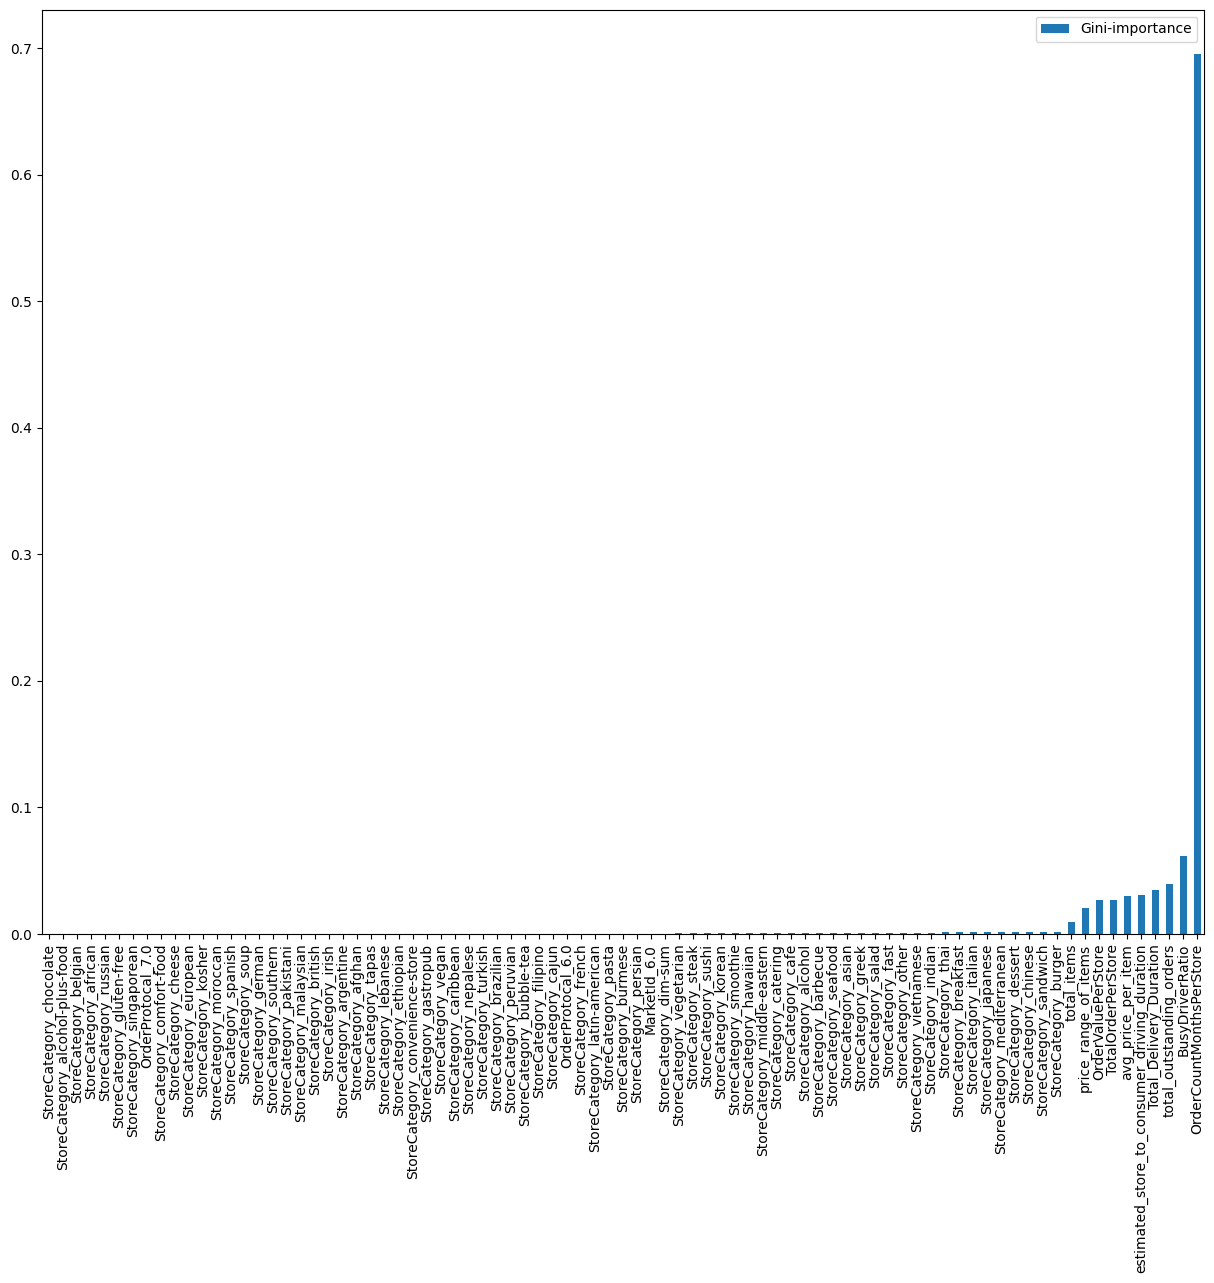

In [55]:
#plotting the feature importance
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, Y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

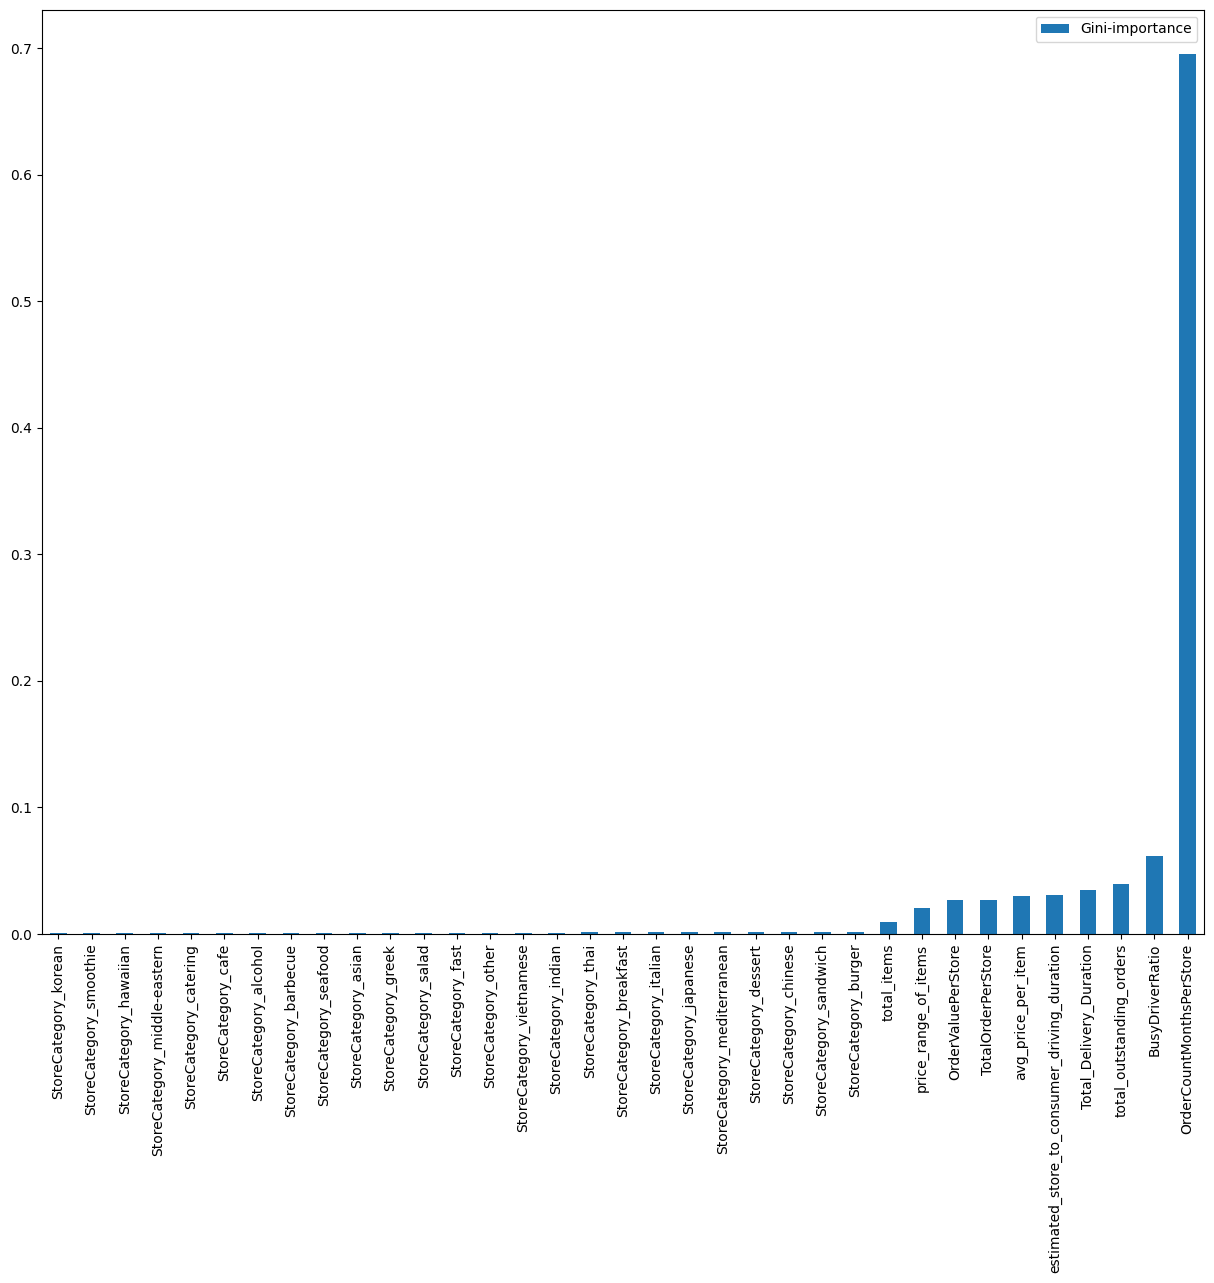

In [86]:
#checking the feature importance
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

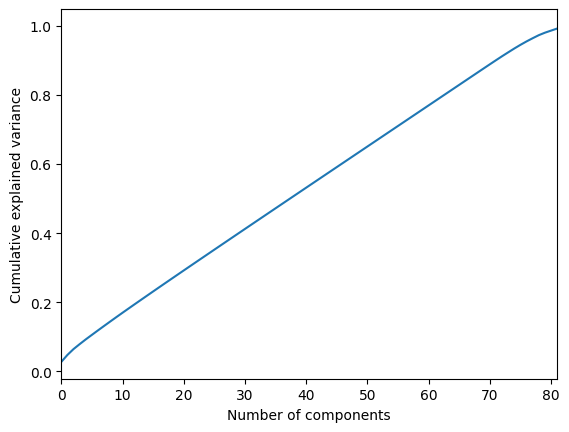

In [ ]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0, 81)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

##PCA shows that around 60-70 components are needed to explain ~80% of the variance in the data which makes the PCA not very useful in this case

In [91]:
#Scaling the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """Apply the scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [ ]:
#minmax scaler
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, Y)
# splitting after scaling 
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)